# Aim  2 Analysis: Characterizing The Dynamics of our Three Populations Using Transcriptomic Analysis

In this notebook, we will be completing our analysis of Days 7 - Day 13 of the CD34+ Cells in LEM. 

The Research Questions of this Aim are: 
1. Is There a Difference in CD7 expression between Days 7, 10 and 13, across all HSCs or within each Population?

2. Is There a Statistical Difference in CD7 Expression Between Ra-C- cells (Primitive), and Ra-C+/C+ Populations (Morer Mature)? 

3. Does the Increase in CD7 Expression statisticallly correlate with an Increase in Known T-Cell Genes?  

4. Do Enriched Clusters of High CD7 Population Also Have High T-Cell Gene Enrichment? (Across all pools, and within each population)

5. Are CD7+ Cells Biased towards a T-lineage Compared to CD7- Cells? 

6. Is There are Correlations Between CD7 and Other CD Markres? 

7. What are the Top Transcriptional Drivers/Regulators in CD7+ Cells? 

## Pre-Processing and Data Preparation


Let's begin by loading any of our necessary libraries, and loading our CITE-Seq data into this notebook: 

In [ ]:
# Loading Libraries

library(BiocSingular) # We need this to use the BioConductor libraries that work on the Single Cell data. #nolint
library(SingleCellExperiment) # We need this to use the SingleCellExperiment data structure.  # nolint
library(ggplot2) # we need this to make ggplot visualizations #nolint
library(tidyr) # we need this to manipulate data #nolint
library(dplyr) # we need this to manipulate data #nolint
library(patchwork) # to display plots side by side. #nolint
library(ggforce) # Allows me to display circles on ggplots. #nolint
library(limma) # helps with differential expression analysis #nolint
library(IRdisplay) # lets me display JPEGs in the notebook #nolint
library(org.Hs.eg.db) # lets me do gene annotation #nolint
library(clusterProfiler) # lets me do gene set enrichment analysis #nolint
library(tidyverse) # lets me manipulate data #nolint
library(broom) # lets me manipulate data #nolint


Once again, refer to `d0_analysis.ipynb` to look at the process by which I have created my sce object. For now, I am going to load it in, instead of repeating the process to save time. Then, I will be adding phenotype data and population markers to this sce object as columns (as down in `Aim1_Analysis.ipynb`). 

In [ ]:
load("data/phenotype_with_ID.RData")
load("data/merge2.RData")

# Adding Phenotype data to the SCE object
pheno.d7 <- rep("CD34+CD45RA-CLEC12A-", 3039)
names(pheno.d7) <- colnames(merge2)[1:3039]

pheno.merge2 <- c(pheno.d7, pheno.d10, pheno.d13)


colData(merge2)$Phenotype <- pheno.merge2


# Cleaning Up the Phenotype Data so it belongs to the 3 populations

# Define phenotype groups
phenotype_groups <- list(
    Raneg_Cneg = c("CD34+CD45RA-CLEC12A-", "CD34-CD45RA-CLEC12A-"), # Ra-C-
    Rapos_Cneg = c("CD34+CD45RA+CLEC12A-", "CD34-CD45RA+CLEC12A-"), # Ra+C-
    Cpos = c("CD34-CD45RA-CLEC12A+", "CD34+CD45RA-CLEC12A+", "CD34+CD45RA+CLEC12A+", "CD34-CD45RA+CLEC12A+"), # C+ # nolint
    Other = c("CD10+", "CD14CD15+") # Pro -B #Pro-NM #FW Gating from a flow cytometer #nolint
)

# Assign group labels to phenotypes
group_labels <- sapply(pheno.merge2, function(phenotype) {
    group <- names(phenotype_groups)[sapply(phenotype_groups, function(g) phenotype %in% g)] # nolint
    if (length(group) > 0) group else "Other"
})

# Add group labels to colData of the SCE object
colData(merge2)$Group <- group_labels


Next, lets add a column indicating which day each observation belongs too, as we will be doing time sensitive analysis in the coming sections as well: 

In [5]:
# Extract the day information from cell names
colData(merge2)$Day <- gsub(".*Day_([0-9]+).*", "\\1", rownames(colData(merge2)))
# Convert to a factor (optional, for better categorical handling)
colData(merge2)$Day <- factor(colData(merge2)$Day, levels = sort(unique(colData(merge2)$Day)))

colnames(colData(merge2))


[1] "Sample"                            "Barcode"                          
 [3] "sum"                               "detected"                         
 [5] "subsets_Mito_sum"                  "subsets_Mito_detected"            
 [7] "subsets_Mito_percent"              "altexps_Antibody Capture_sum"     
 [9] "altexps_Antibody Capture_detected" "altexps_Antibody Capture_percent" 
[11] "total"                             "sizeFactor"                       
[13] "label"                             "scDblFinder.cluster"              
[15] "scDblFinder.class"                 "scDblFinder.score"                
[17] "scDblFinder.weighted"              "scDblFinder.difficulty"           
[19] "scDblFinder.cxds_score"            "scDblFinder.mostLikelyOrigin"     
[21] "scDblFinder.originAmbiguous"       "batch"                            
[23] "Phenotype"                         "Group"                            
[25] "Day"

Nice! As a Sanity Check, let's explore the makeup of the 3 populations, and their timepoints, using a simple tibble: 

In [6]:
table(colData(merge2)$Group, colData(merge2)$Day)


            
               10   13    7
  Cpos       1407 2219    0
  Other       264 1023    0
  Raneg_Cneg 1815  608 3039
  Rapos_Cneg  766 1040    0

* Day 7 data exists only for Raneg_Cneg (i.e., primitive/early cells).

* Day 10 and Day 13 have more mature populations like Cpos and Rapos_Cneg.

This makes sense developmentally and supports the  idea that CD7 expression might increase over time as cells mature.

Finally, since CD7 does not exist inthe ADT Assay of the Cite-Seq data (that is, Fangwu did not tag the antibody with a fluorochrome during experimental setup), we can't use Flow Cytometry to gate positive and negative populations. Instead, we will have to rely on the CD7 gene RNA Distribution and attempt to annotate a CD7+ population and CD7- population. 

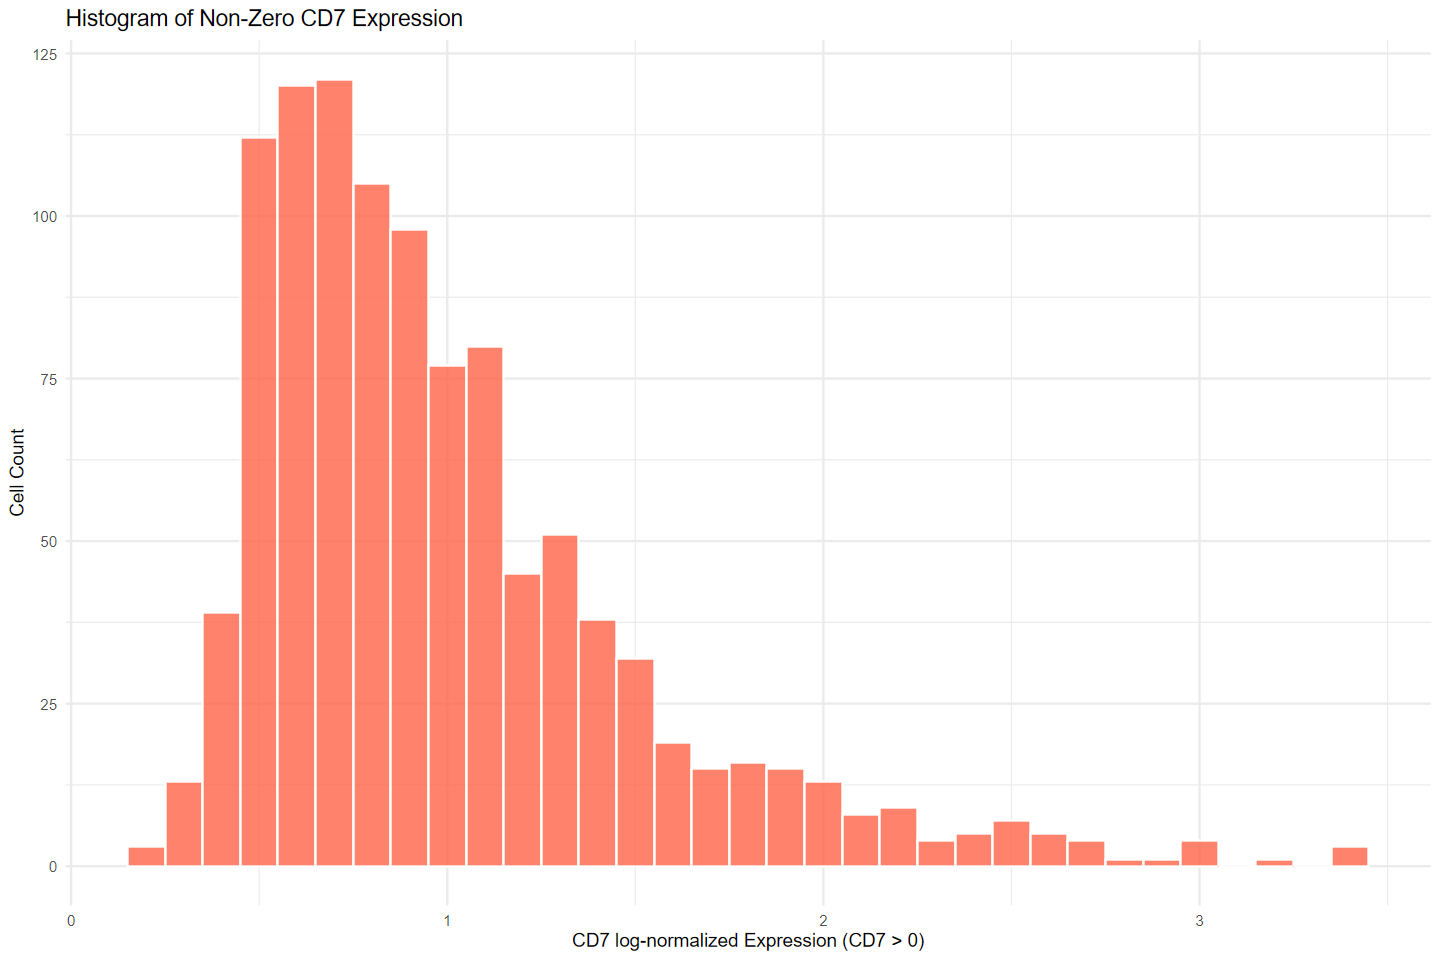

In [ ]:
# Creating a Violin Plot to Generate CD7 Distribution Across All Cells Overall

options(repr.plot.width = 12, repr.plot.height = 8)

# 1. Extract CD7 expression from the RNA assay
cd7_expr <- logcounts(merge2)["CD7", ]


# 2. Add CD7 expression to metadata
colData(merge2)$CD7_expr <- cd7_expr

# Filter to cells with CD7_expr > 0
# becuase otherwise the plot becomes right skewed and useless
nonzero_df <- as.data.frame(colData(merge2)) %>%
  filter(CD7_expr > 0)

# Plot histogram of non-zero CD7 expression
ggplot(nonzero_df, aes(x = CD7_expr)) +
  geom_histogram(binwidth = 0.1, fill = "tomato", color = "white", alpha = 0.8) +
  labs(
    title = "Histogram of Non-Zero CD7 Expression",
    x = "CD7 log-normalized Expression (CD7 > 0)",
    y = "Cell Count"
  ) +
  theme_minimal()


Nice! We can see the clean distribution using this histogram! Here's my interpretation of it: 

* There's a dense peak between ~0.5 to ~1.5, with a long right-skewed tail extending up to ~3.2.
* This suggests a natural break point between low-but-detectable CD7 expression and robust CD7⁺ expression.

So this is the gating structure I will be implementing, based on this: 
CD7 Status | Expression Range (CD7_expr)	| Rationale|
-----------|--------------------------------|----------|
CD7⁻	|≤ 0	|Truly negative|
CD7-low	|> 0 & < 1	|Weak expression; transitional or noise|
CD7⁺	|≥ 1	|Stronger, confident expression|

Let implement it in the code chunk below: 

In [ ]:
colData(merge2)$CD7_status <- case_when(
  merge2$CD7_expr == 0 ~ "CD7_neg",
  merge2$CD7_expr >= 1 ~ "CD7_pos",
  TRUE ~ "CD7_low" # Optional middle category
)


Great! We are now ready to begin working on the first Research Question of this analysis. 

## Analysis Workflow 


### RQ1: Is There a Difference in CD7 expression between Days 7, 10 and 13, across all HSCs or within each Population?

CD7 may be a marker that increases as cells progress towards a T-lineage. Understanding its temporal dynamics across differentiation days should be the first sanity check we conduct to see if it is actually doing anything. The overall population of cells are maturing over time in LEM culture (which is designed to support Lymphoid specificiation). CD7 is a surface marker that is belived to be enriched in early T-lineage committed cells. 

Given that the progression of populations from Day 7 to Day 13 involves a lot of maturation and lineage specification, one would expect to see higher levels of CD7 as time progresses across the overall CD34+ HSC population as a whole, and within each of the individual population subsets. 

This is what we will explore and interpret in this section. We will do so in 2 phases: 

* **Phase 1 - Quantitiative CD7 RNA Trend over time**: We will plot CD7 RNA Expression across Days 7, 10 and 13, (across all HSCs, and within each population group), and then conduct statistical testing to compare CD7 across timepoints. 

* **Phase 2- CD7 Positivity Proprtion Over Time**: Will Visualize the propertoin of CD7+ positivity as time progresses, helping see qualitatively if CD7 increases with time. 

Lets begin with implementing phase 1

#### Phase 1: Quantitative CD7 RNA Trend Over Time


I will generate 2 plots here, Plot_1 containing CD7 expression Vs. Day (All HSCs, filtering CD7+/Low only), and Plot_2 containing Plot_1, but faceted by population (3 Pops, filtering CD7+/Low only): 

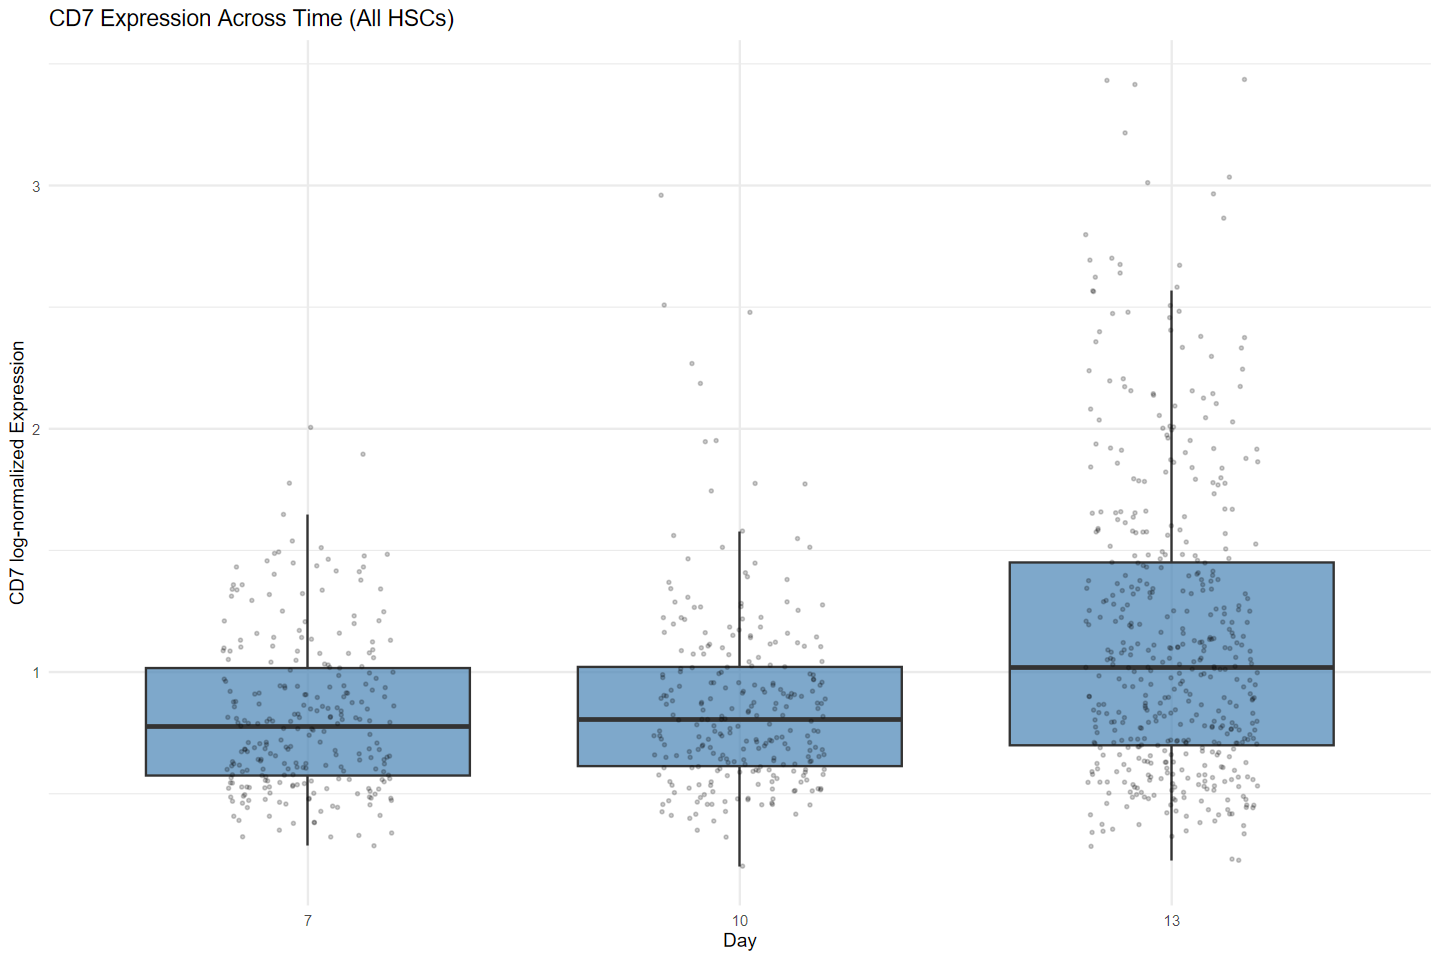

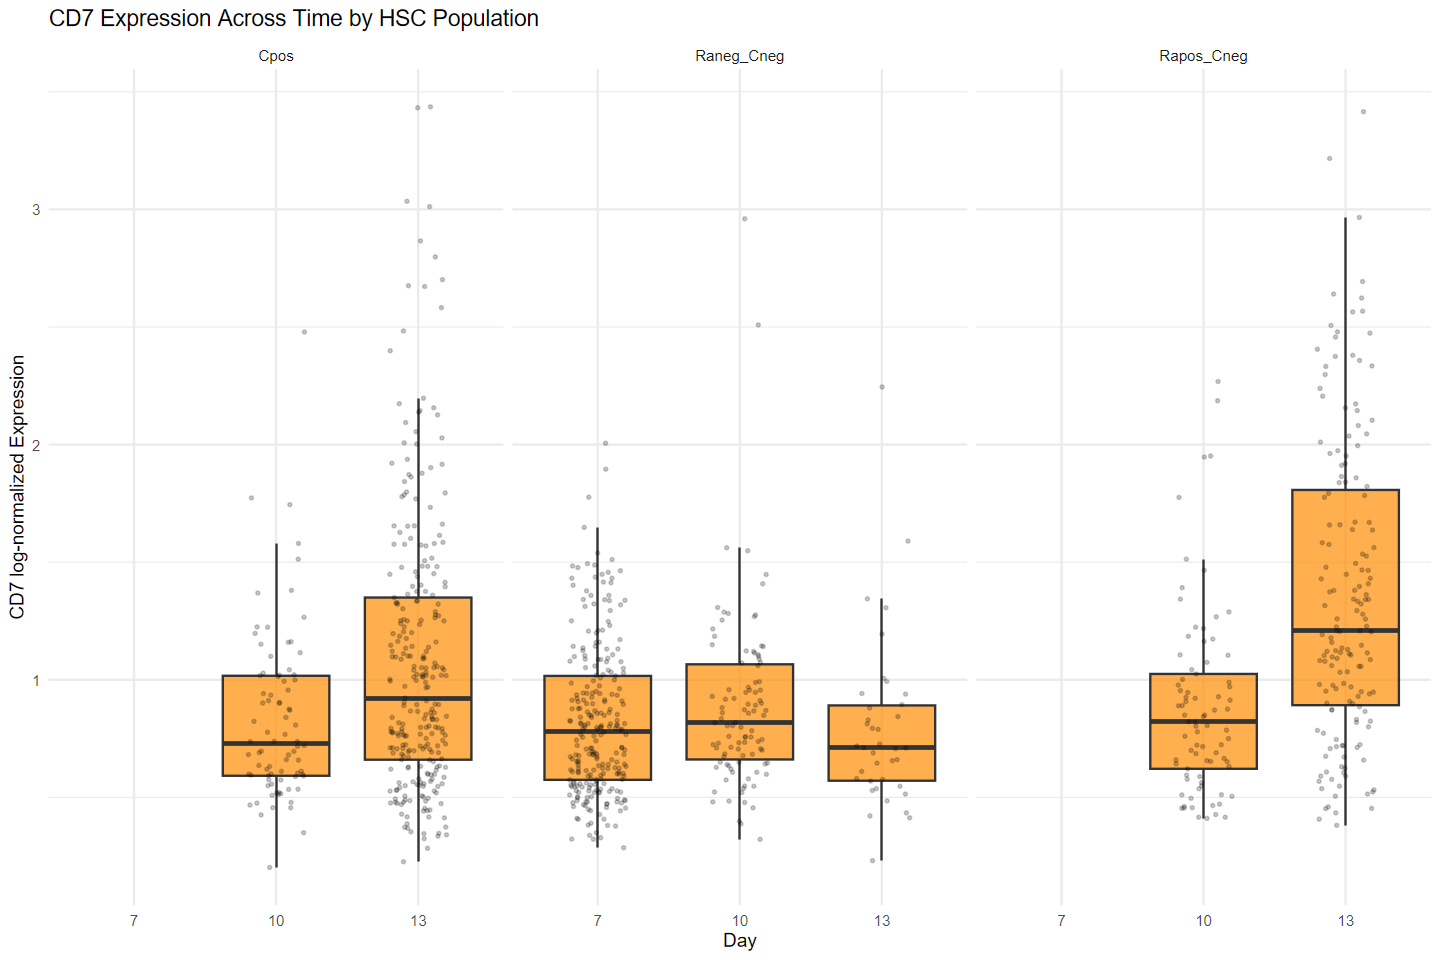

In [ ]:
# Implementing the BoxPlot Visualizations for CD7 Expression Across All Popuulations

options(repr.plot.width = 12, repr.plot.height = 8)
# Filter out CD7- cells
cd7_filtered_df <- as.data.frame(colData(merge2)) %>%
  filter(CD7_status != "CD7_neg") %>%
  filter(Group != "Other")

# Reorder Day as a factor with levels in desired order
cd7_filtered_df$Day <- factor(cd7_filtered_df$Day, levels = c("7", "10", "13"))

# Plot 1: Overall Boxplot (All groups combined)
ggplot(cd7_filtered_df, aes(x = Day, y = CD7_expr)) +
  geom_boxplot(fill = "steelblue", alpha = 0.7, outlier.shape = NA) +
  geom_jitter(width = 0.2, alpha = 0.2, size = 0.5) +
  labs(
    title = "CD7 Expression Across Time (All HSCs)",
    x = "Day",
    y = "CD7 log-normalized Expression"
  ) +
  theme_minimal()

# Plot 2: Faceted by Population Group
ggplot(cd7_filtered_df, aes(x = Day, y = CD7_expr)) +
  geom_boxplot(fill = "darkorange", alpha = 0.7, outlier.shape = NA) +
  geom_jitter(width = 0.2, alpha = 0.2, size = 0.5) +
  facet_wrap(~Group) +
  labs(
    title = "CD7 Expression Across Time by HSC Population",
    x = "Day",
    y = "CD7 log-normalized Expression"
  ) +
  theme_minimal()


Here's my interpretations of what I am seeing: 

---
**Plot 1: CD7 Expression Across Time (All HSCs)**
- **Trend:** There is a **clear increase** in CD7 expression from Day 7 → Day 13.
- Median CD7 expression appears to **increase steadily**, and there’s a visible rise in the spread of values on Day 13.
- Day 13 shows a broader interquartile range (IQR) and more extreme outliers — suggesting **higher transcriptional heterogeneity** in CD7⁺ cells over time.
- **Interpretation:** This supports the idea that **CD7⁺ cells become more prominent or transcriptionally active as differentiation proceeds**, consistent with increasing T-lineage priming over time.
---
**Plot 2: CD7 Expression Across Time by Population**
- This is **really insightful** for dissecting cell-type-specific dynamics. Here’s what we can see:
**Cpos (C⁺)**
- Starts with moderate expression on Day 10, and by Day 13 CD7 expression is **dramatically higher**.
- Strongest rise among all populations.
- This might indicate that **C⁺ cells are strongly acquiring T-lineage bias** as time progresses.

**Rapos_Cneg (Ra⁺C⁻)**
- Similar to Cpos, with a noticeable bump in expression by Day 13.
- Suggests this population is **also transitioning**, though perhaps slightly delayed or with more heterogeneity.

**Raneg_Cneg (Ra⁻C⁻)**
- Expression is relatively flat across all timepoints.
- This supports the idea that Ra⁻C⁻ cells are **maintaining a primitive state** with **minimal T-lineage activation**.
---

**Summary Takeaways**
- **CD7 expression increases over time** across all cells, particularly in **Ra⁺C⁻ and C⁺ populations**.
- **Ra⁻C⁻ cells remain low and flat**, suggesting **they are least committed to T-lineage** — reinforcing their use as a baseline for comparison.
- This aligns well with your Aim 2 question: **“Does CD7 enrich for T-cell bias?”** → you're seeing evidence that **CD7 tracks with populations known to acquire T-cell characteristics over time**.

Let's follow this up with a statisticial analysis by fitting a SLR model on the entire HSC population: 

In [ ]:
cd7_day_slr <- lm(CD7_expr ~ Day, data = cd7_filtered_df)

tidy(cd7_day_slr)


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.82270538,0.03099045,26.547058,1.358152e-117
Day10,0.04823789,0.04361752,1.105929,2.690270e-01
Day13,0.32967080,0.03854306,8.553311,4.517974e-17


Great! Here's the meaning of these results, as taught to me in STAT 301: 

* There is enough statistical evidence to make the claim that the mean log-CD7 expression in all HSCs (regardless of population) of the reference level (Day7) is 0.823, and is statistically significant at p < 0.05. 
* There is not enough statistical evidence to make the claim that the mean log-CD7 expression in all HSCs (regardless of population) of Day 10 cells is different from the Day 7 cells. 
* There is enough statistical evidence to make the claim that the mean log-CD7 expression in all HSCs (regardless of population) of Day 13 cells is 0.03 more than the Day 7 cells, at p < 0.05. 

Let's now repeat this experiment by focusing on the interaction between time and population, worked on below: 

In [ ]:
# relevelling so Ra-C- is the reference level
cd7_filtered_df$Group <- factor(cd7_filtered_df$Group)
cd7_filtered_df$Group <- relevel(cd7_filtered_df$Group, ref = "Raneg_Cneg")

# relevelling so Day 10 is the reference level
cd7_filtered_df$Day <- relevel(cd7_filtered_df$Day, ref = "10")

cd7_daygroup_slr <- lm(CD7_expr ~ Day * Group, data = cd7_filtered_df)

tidy(cd7_daygroup_slr)


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.889509825,0.04860987,18.29895522,1.367600e-64
Day7,-0.066804442,0.05721144,-1.16767626,2.432208e-01
Day13,-0.097935558,0.09229814,-1.06107837,2.889152e-01
GroupCpos,-0.056651580,0.07221989,-0.78443183,4.329759e-01
GroupRapos_Cneg,-0.002703804,0.07246332,-0.03731272,9.702432e-01
Day7:GroupCpos,NA,NA,NA,NA
Day13:GroupCpos,0.344717880,0.11058310,3.11727451,1.878406e-03
Day7:GroupRapos_Cneg,NA,NA,NA,NA
Day13:GroupRapos_Cneg,0.574620773,0.11348220,5.06353201,4.913448e-07


Here's the meaning of these results: 

* `(Intercept)`: There is enough statistical evidence to make the claim that the mean log-CD7 expression for Ra-C- cells at Day 10 is 0.89, and this is statistically significant (p < 0.05).
* `Day7`: There is not enough evidence to make the claim that the mean CD7 expression in Ra-C- cells at Day 7 differs from Day 10
* Day13`: There is not enough evidence to make the claim that the mean CD7 expression in Ra-C- cells at Day 13 differs from Day 10.
>*This means CD7 expression in Ra-C- population does not chhange with time.*
--
* `GroupCPos`: There is not enough evidence to make the claim that the mean CD7 expression in C+ cells at Day 7 differs from Ra-C- cells at Day 10.
* `GroupRapos_Cneg`: There is not enough evidence to make the claim that the mean CD7 expression in Ra+C- cells at Day 7 differs from Ra-C- cells at Day 10.
>*No statiatical difference in CD7 expression among populations on Day 7 compared to Day 10*
--
* `Day13:GroupCpos`: There is enough statistical evidence to  claim that the Day 13 C+ cells have a 0.345 higher log-CD7 expression than Ra-C- cells at Day 10, based on the individual effects of being C+ and Day 13 alone.
* `Day13:GroupRapos_Cneg`: There is strong statistical evidence to  claim that Day 13 Ra+C- cells have a 0.57 higher CD7 expression than Ra-C- cells at Day 10 based on the effects of being Ra+C- and Day 13 alone. 
>These interaction effects support the idea that CD7 expression increases specifically in more mature HSCs over time — especially in populations like Ra+C-, possibly marking T-lineage priming.

#### Phase 2: Quantitative CD7 RNA Proportion Over Time

Let us now evaluate the proportion of CD7 expression over time (Phase 2 of our analysis): 

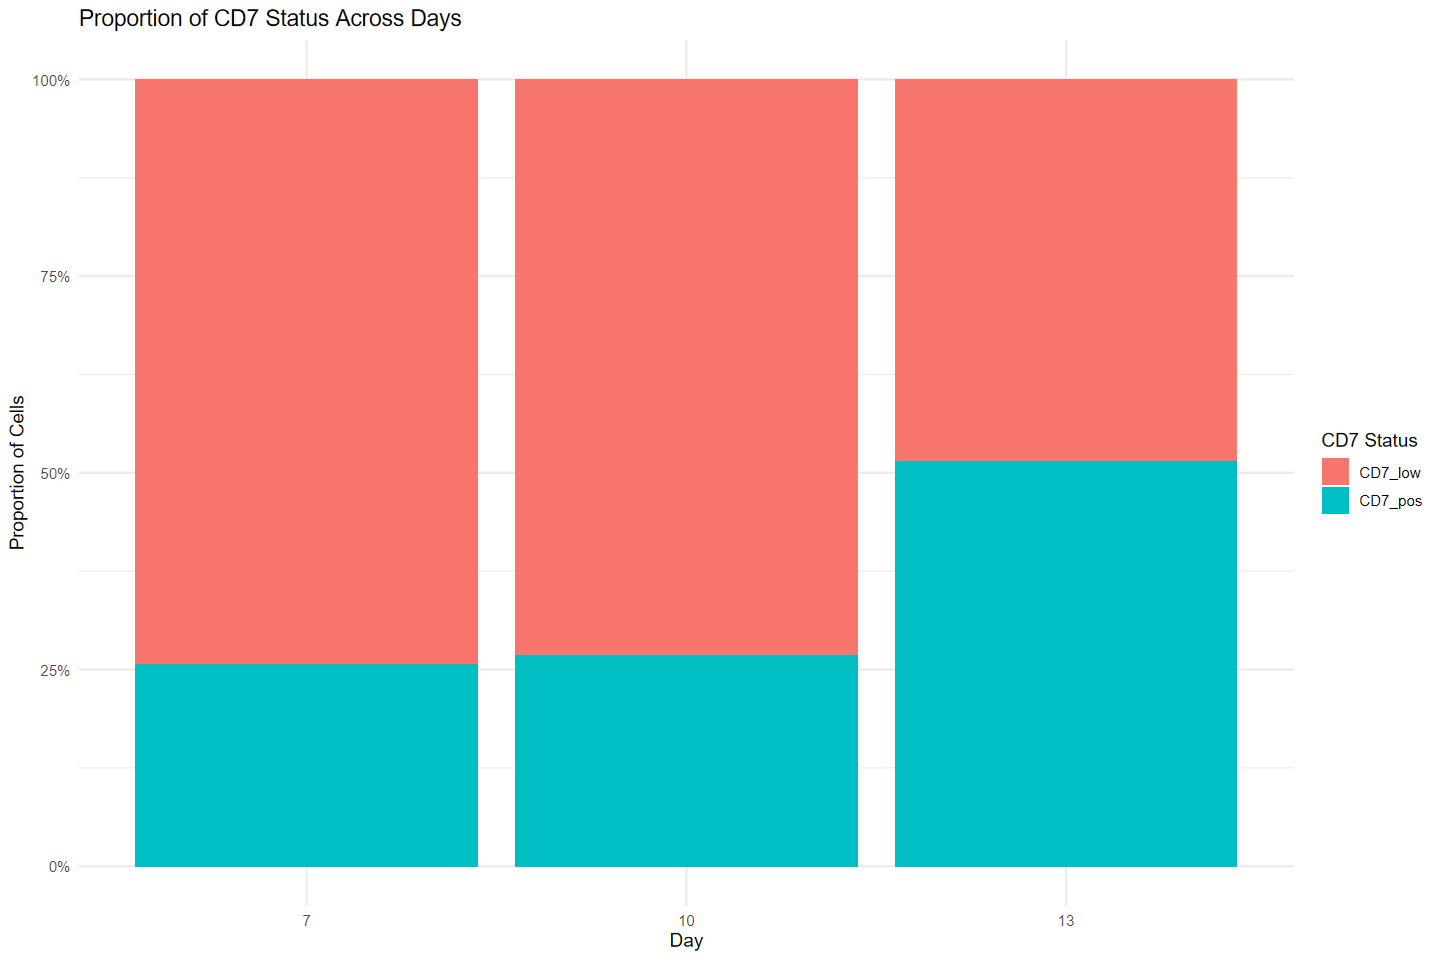

In [47]:
# Ensure Day is a factor in the right order
cd7_filtered_df$Day <- factor(cd7_filtered_df$Day, levels = c("7", "10", "13"))

# Create the normalized stacked bar plot
ggplot(cd7_filtered_df, aes(x = Day, fill = CD7_status)) +
  geom_bar(position = "fill") +
  scale_y_continuous(labels = scales::percent_format()) +
  labs(
    title = "Proportion of CD7 Status Across Days",
    x = "Day",
    y = "Proportion of Cells",
    fill = "CD7 Status"
  ) +
  theme_minimal()


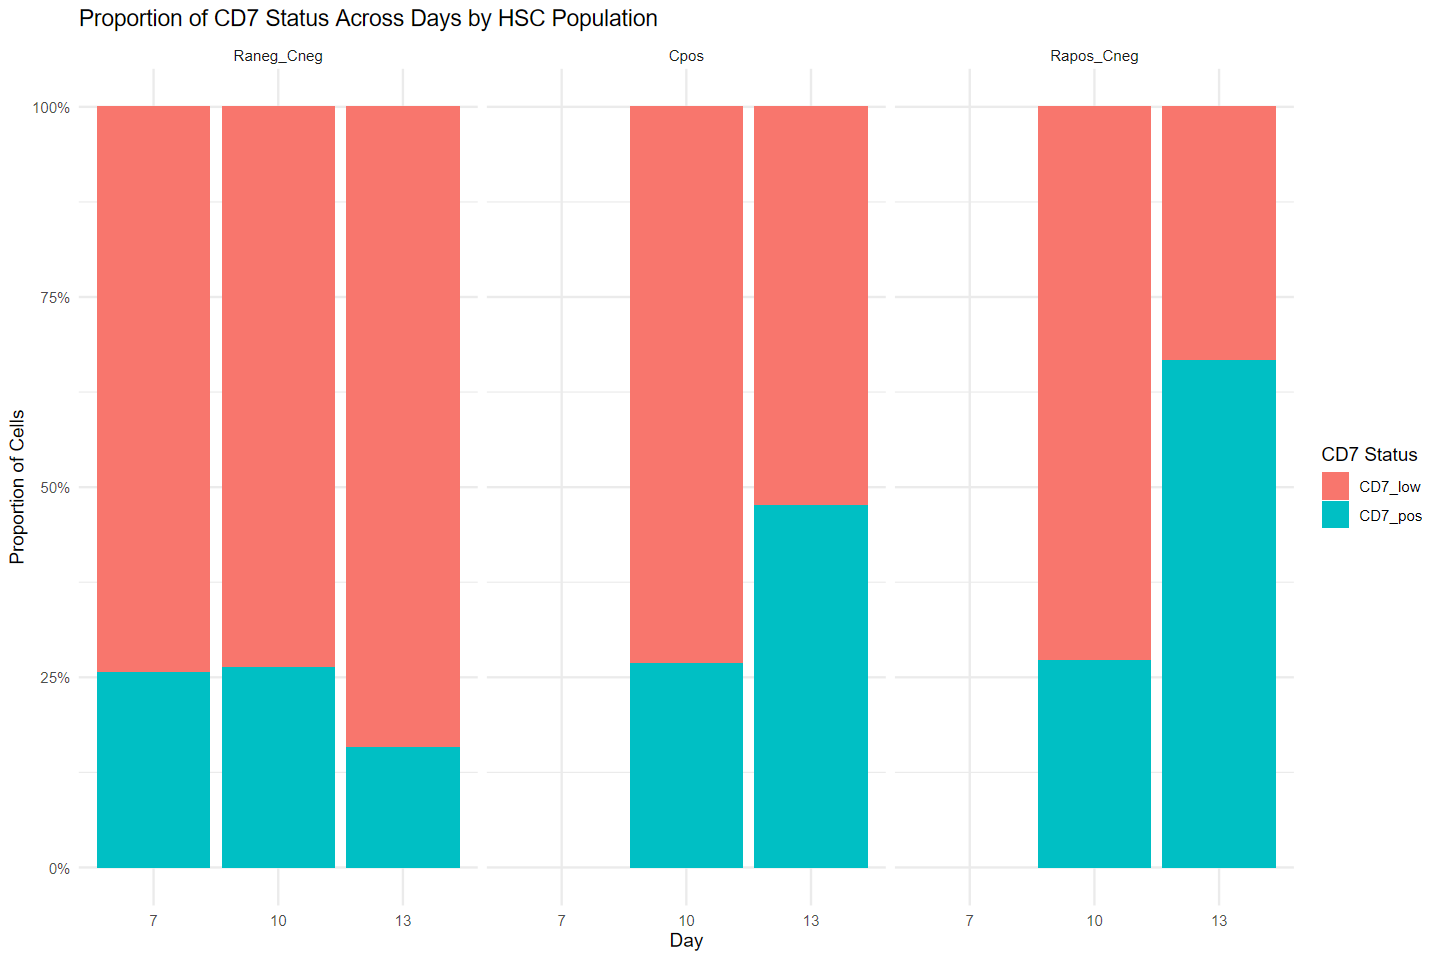

In [ ]:
ggplot(cd7_filtered_df, aes(x = Day, fill = CD7_status)) +
  geom_bar(position = "fill") +
  scale_y_continuous(labels = scales::percent_format()) +
  labs(
    title = "Proportion of CD7 Status Across Days by HSC Population",
    x = "Day",
    y = "Proportion of Cells",
    fill = "CD7 Status"
  ) +
  facet_wrap(~Group) +
  theme_minimal()


Here’s my  interpretation of the two figures:
---
**Figure 1: Proportion of CD7 Status Across Days (All HSCs)**
- **CD7⁺ cells increase from Day 7 to Day 13**, showing a rising trend in CD7 expression over time in the HSC population as a whole.
- This suggests that **CD7 expression may be associated with HSC maturation or progression over time**.
---
**Figure 2: Proportion of CD7 Status Across Days by HSC Population**
- **Cpos and Rapos_Cneg populations show a strong increase in CD7⁺ cells by Day 13**.
- **RaNeg_Cneg remains mostly CD7⁻ across all timepoints**, indicating it retains a more primitive phenotype.
- This supports the idea that **CD7 expression marks more mature or lineage-committed HSCs**, particularly T-lineage-biased ones.

This sets us up beautifully to explore the RQ2 next: 

### RQ2: Is There a Statistical Difference in CD7 Expression Between Ra-C- cells (Primitive), and Ra-C+/C+ Populations (More Mature)? 